C:\Users\ChenLab\Desktop\set_up_data_analysis\V3_update\graphing_function_recent.py:485: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


25.427505330490405


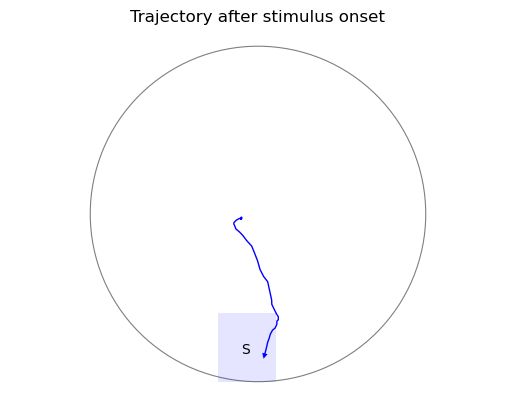

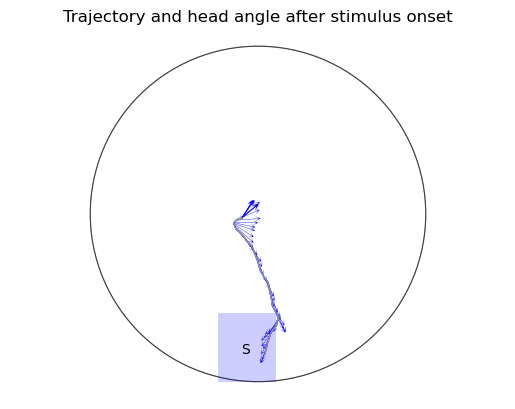

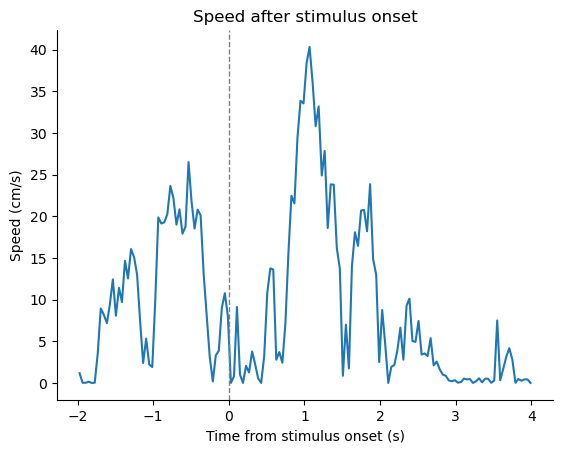

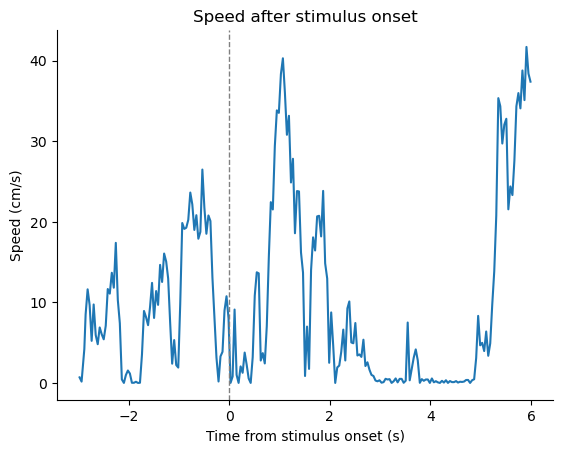

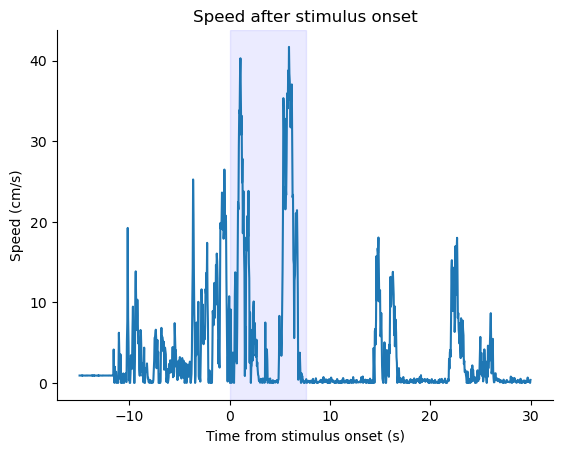

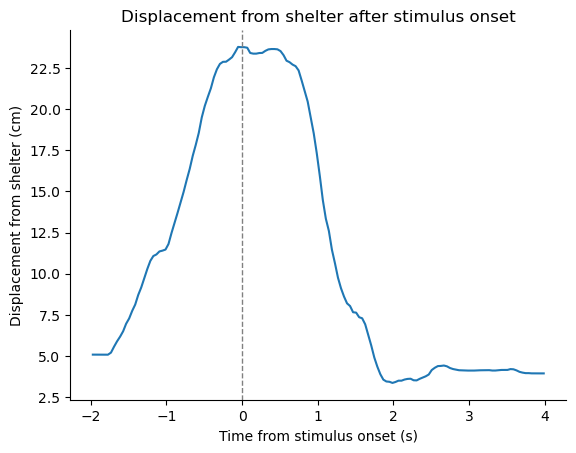

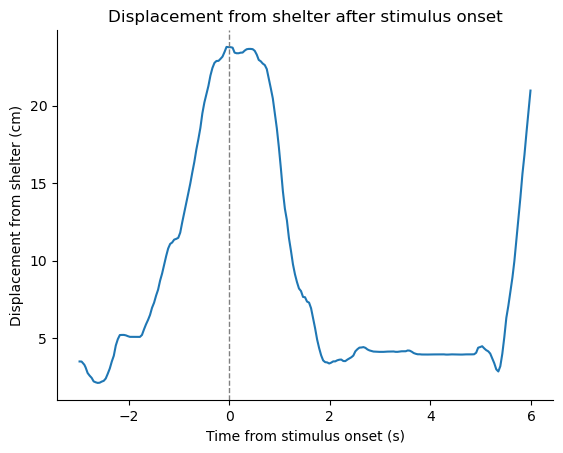

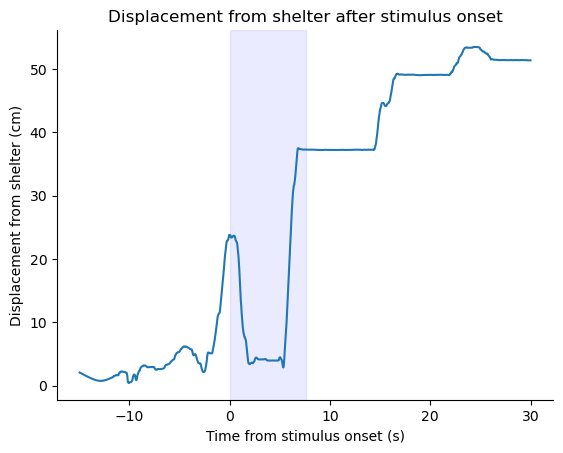

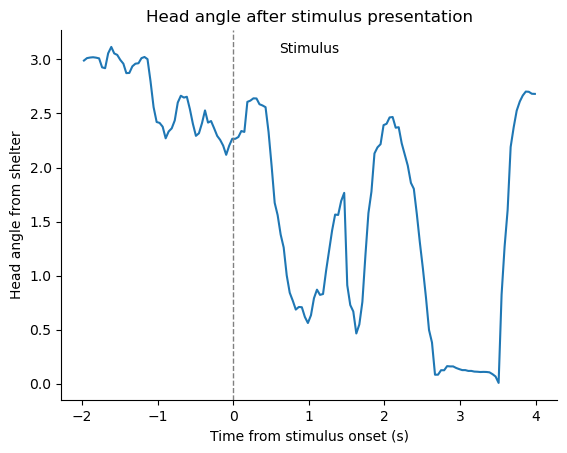

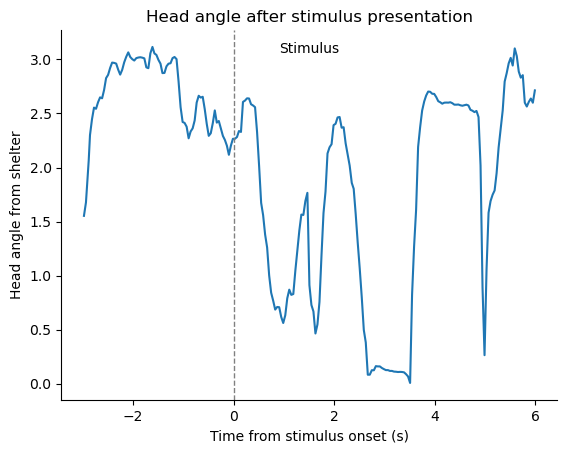

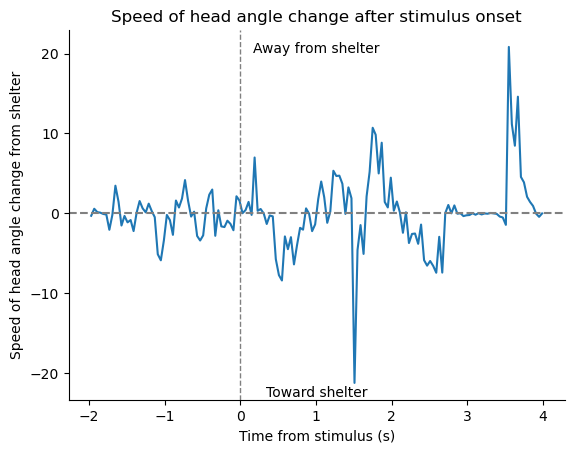

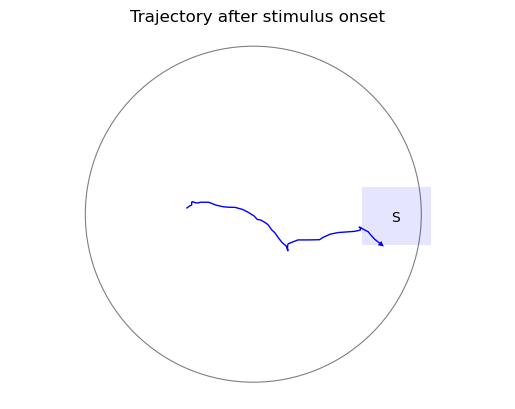

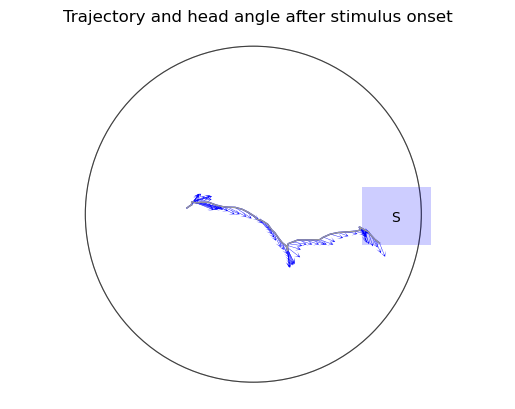

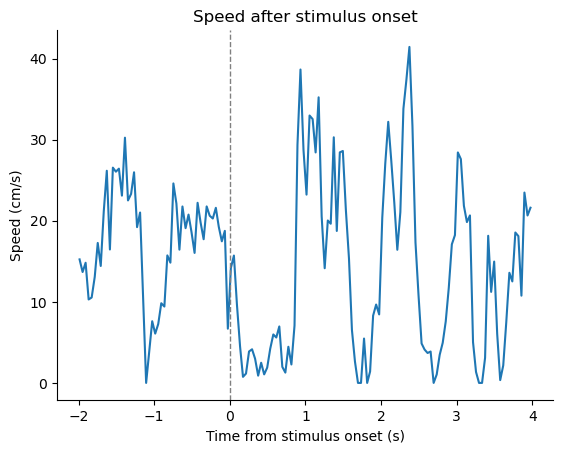

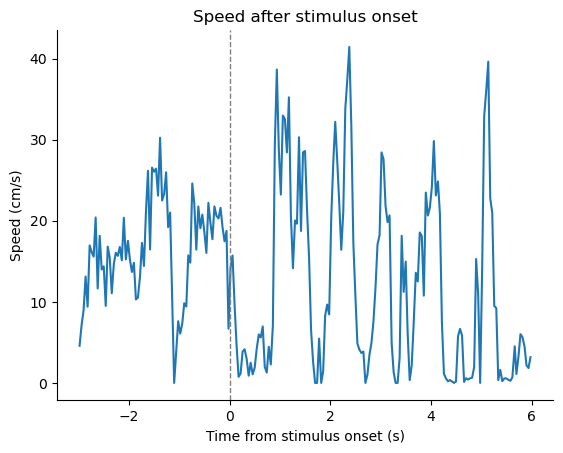

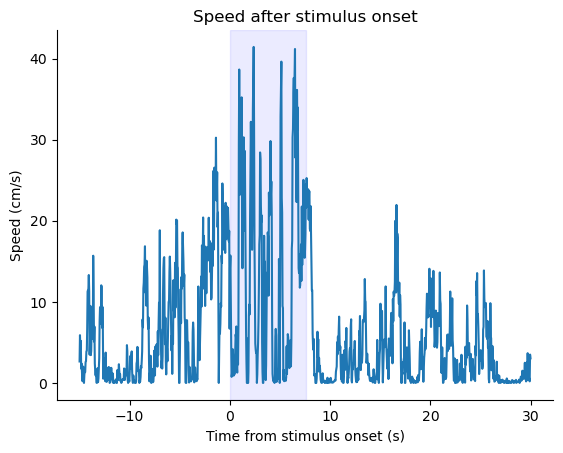

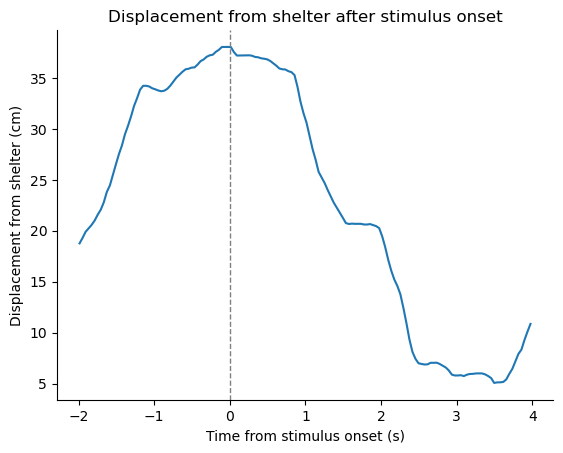

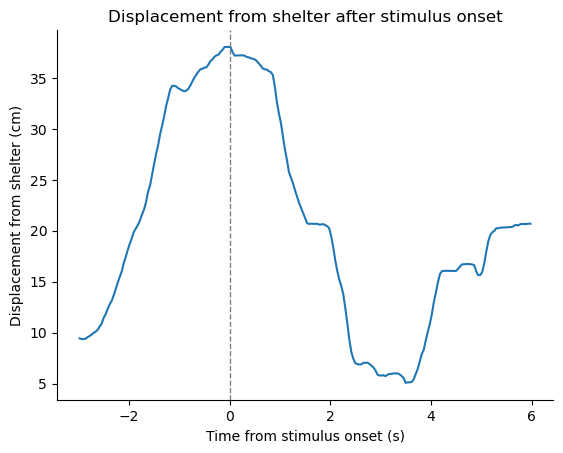

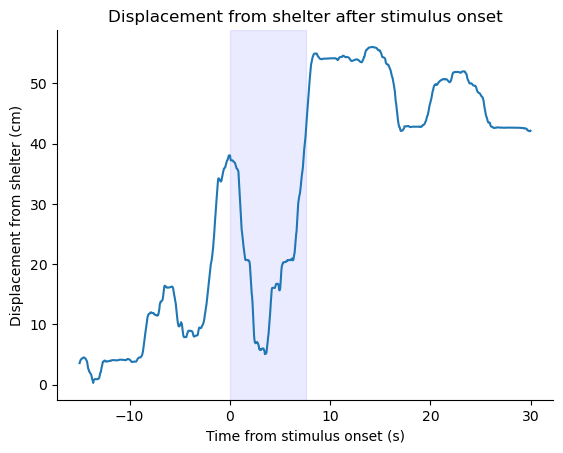

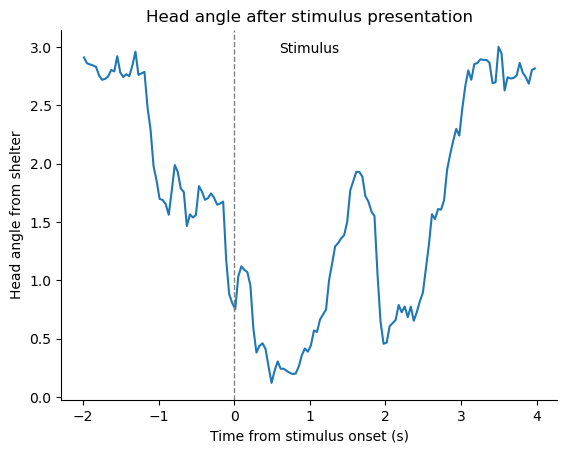

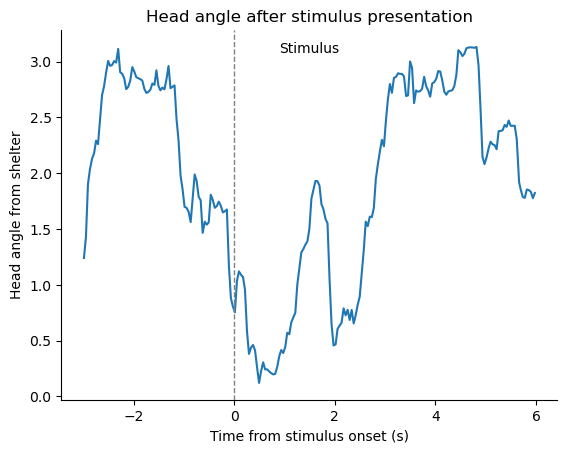

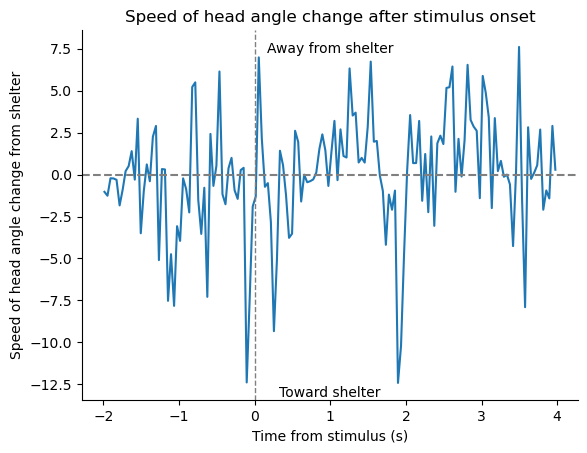

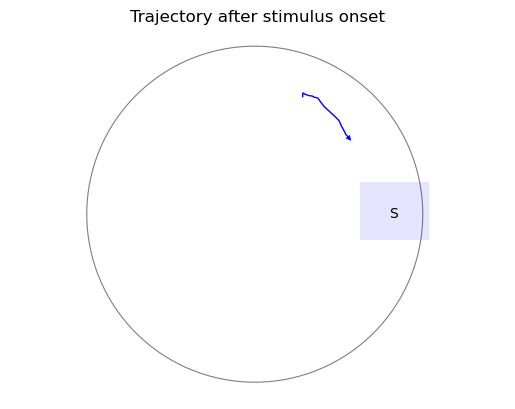

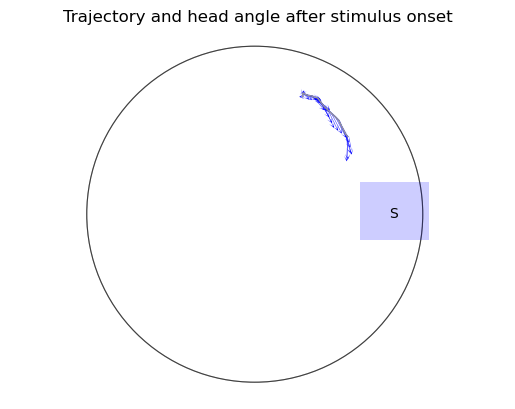

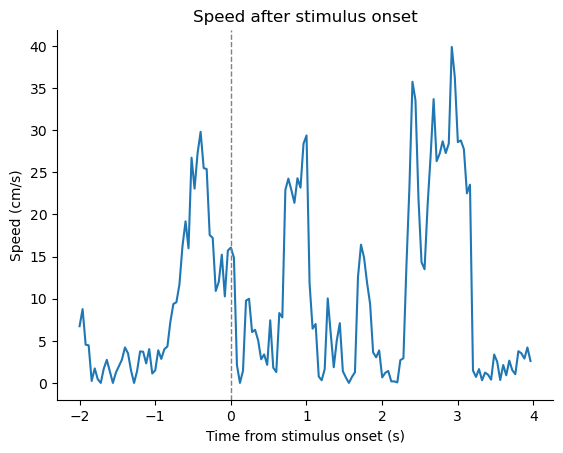

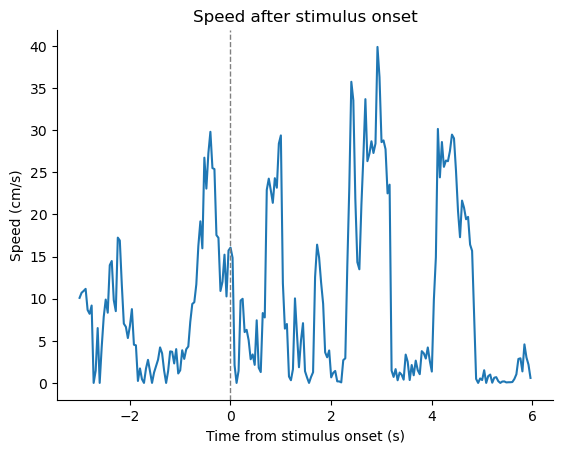

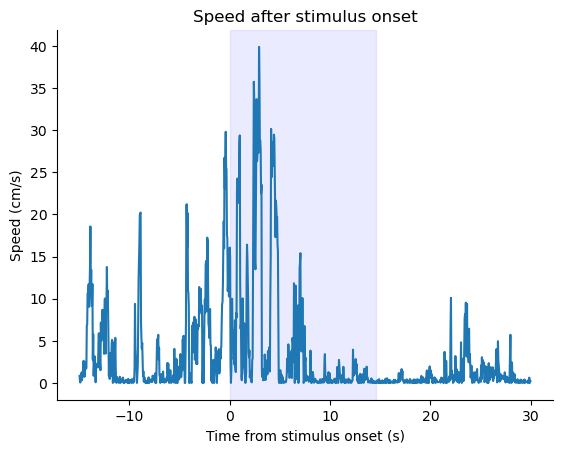

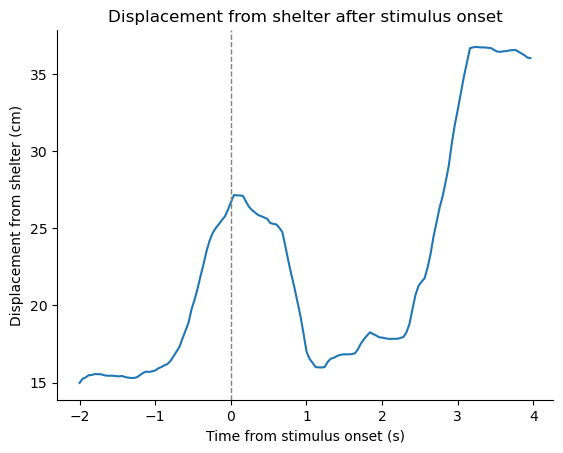

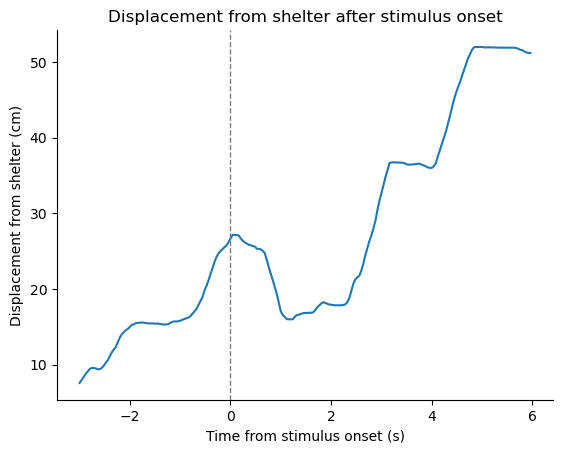

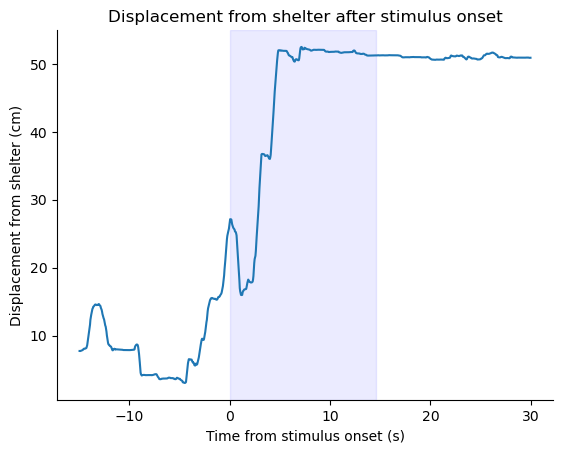

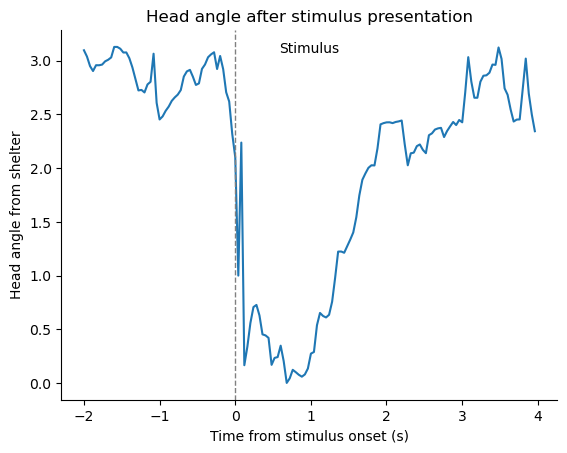

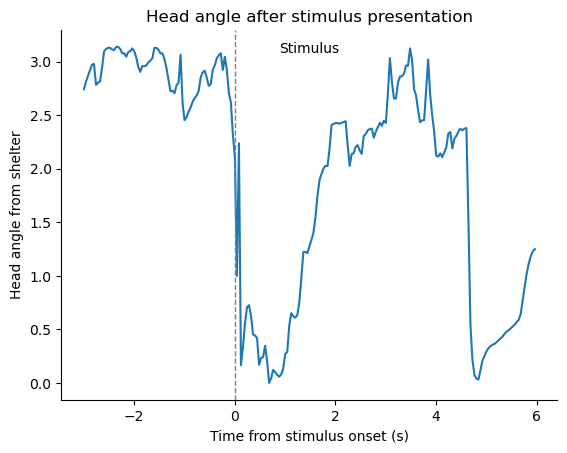

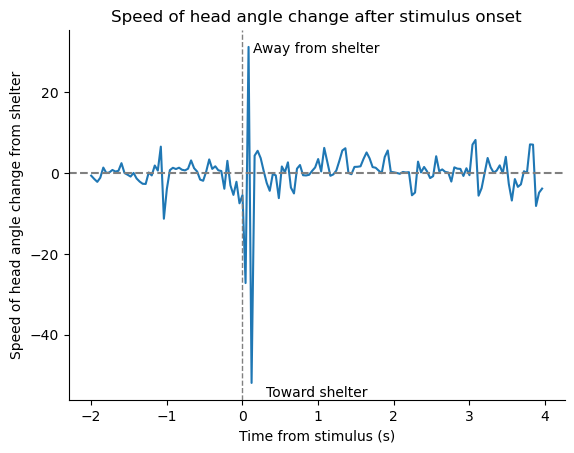

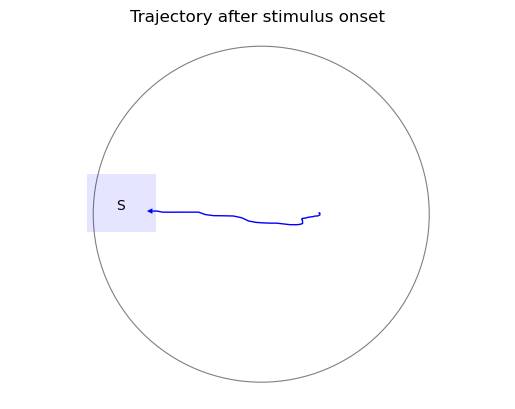

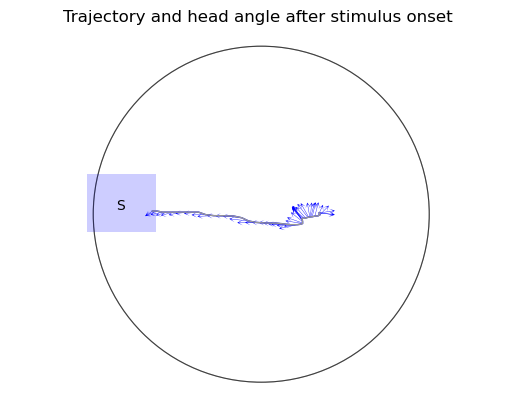

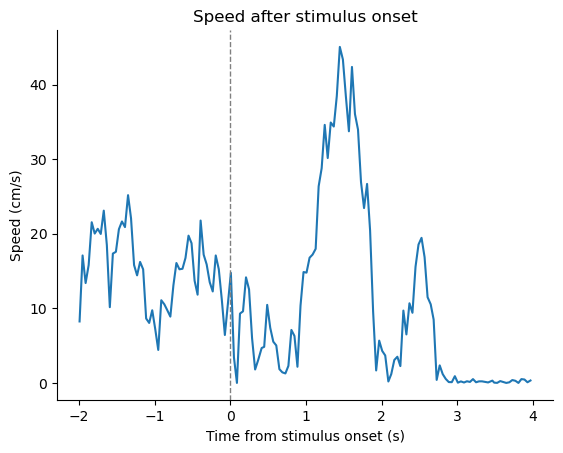

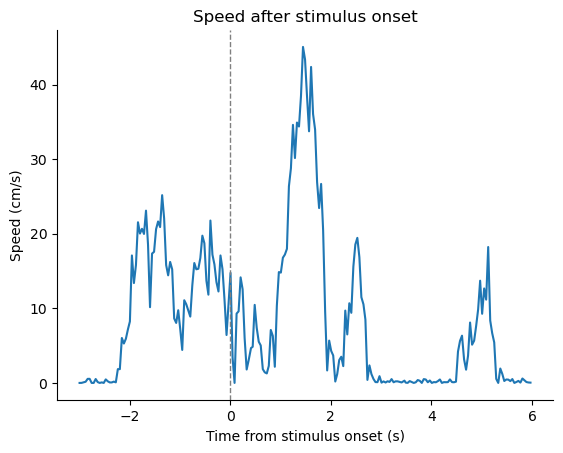

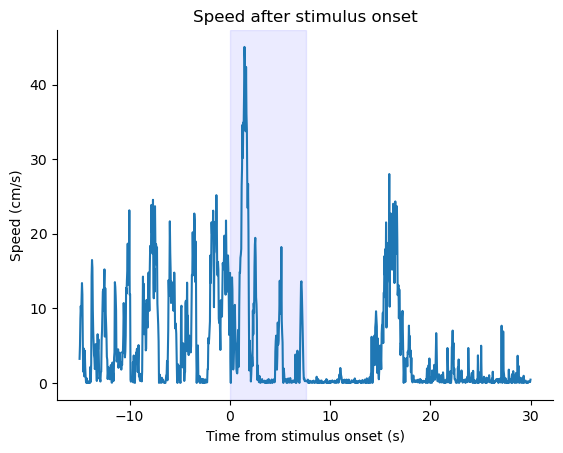

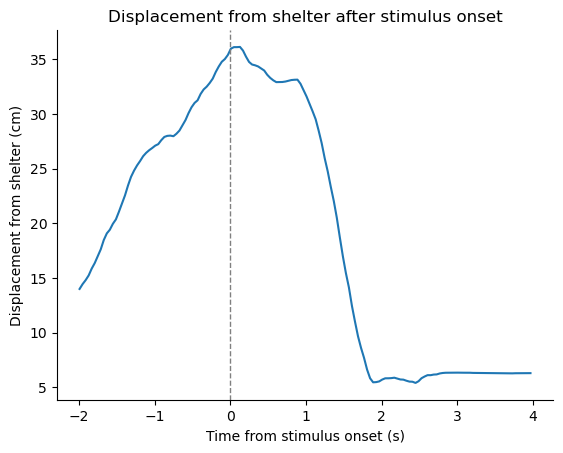

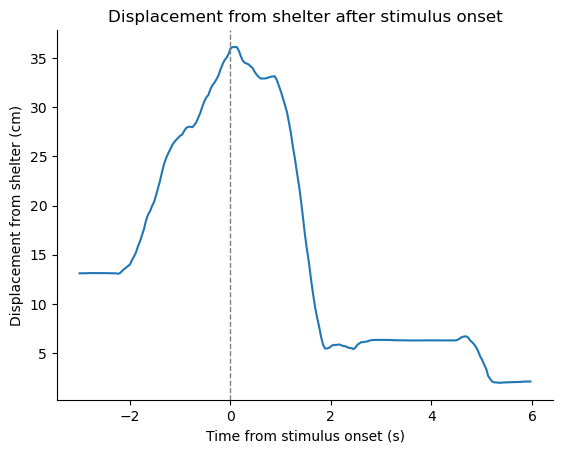

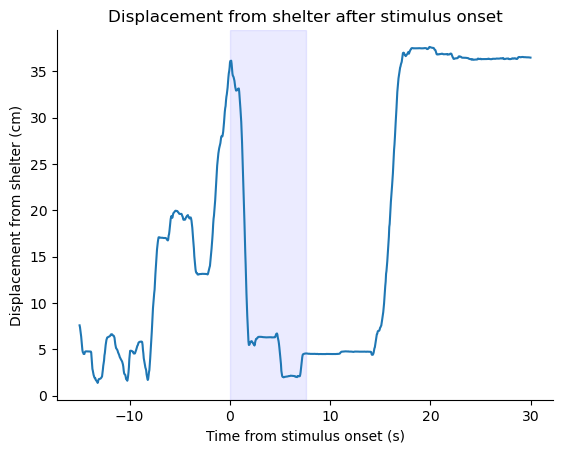

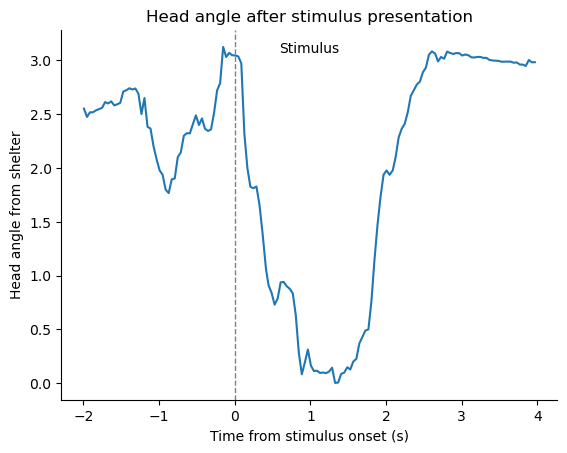

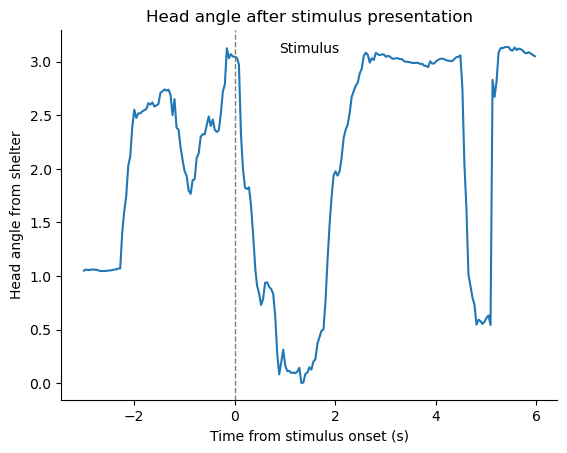

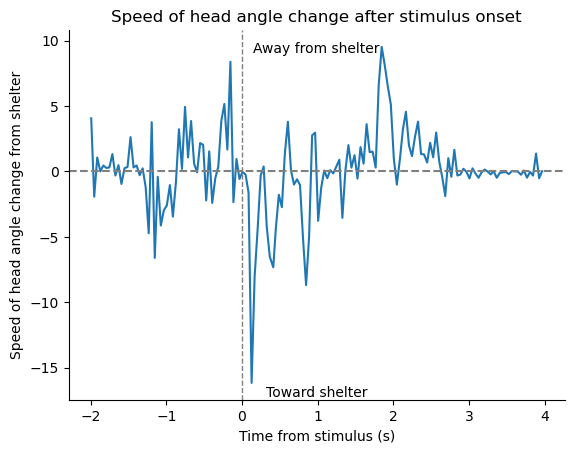

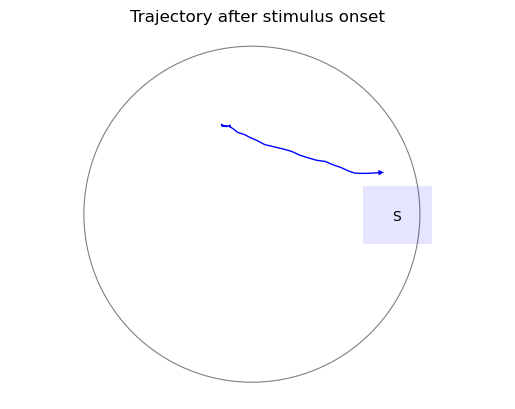

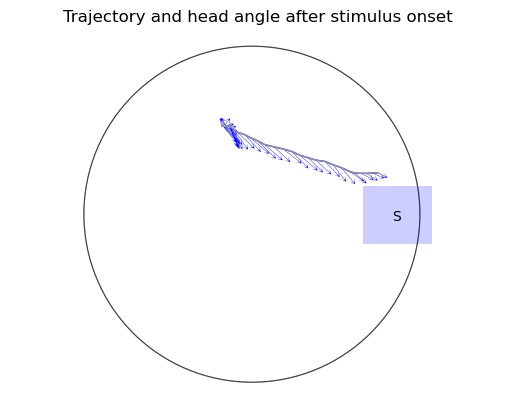

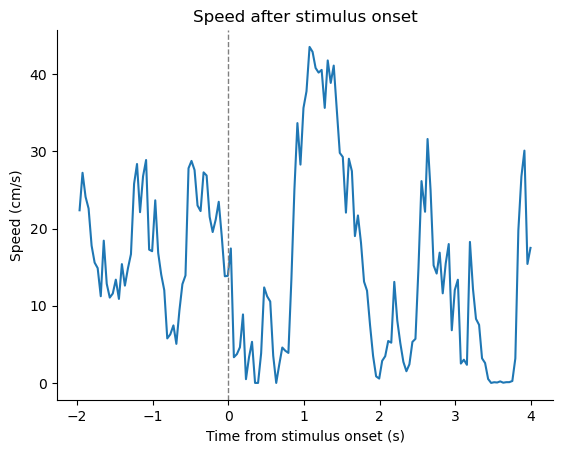

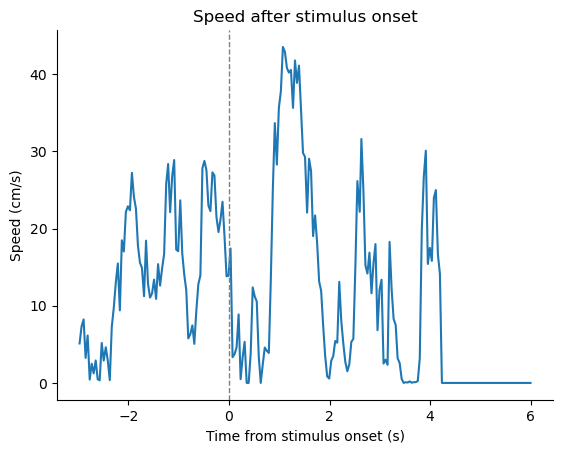

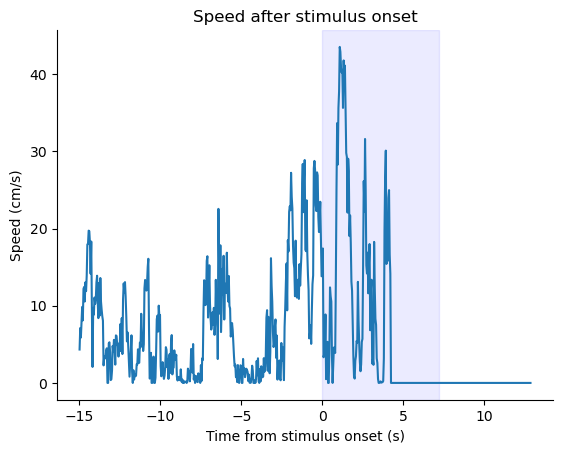

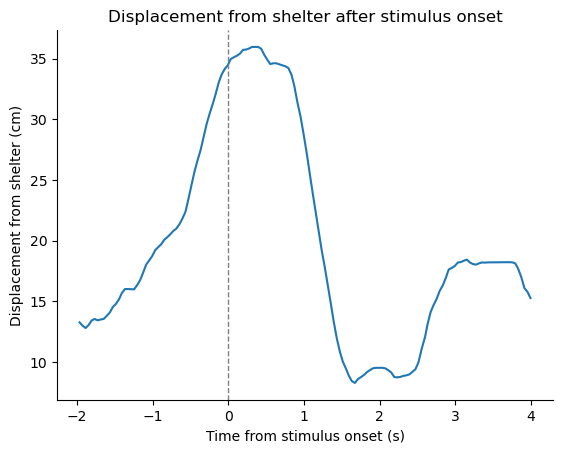

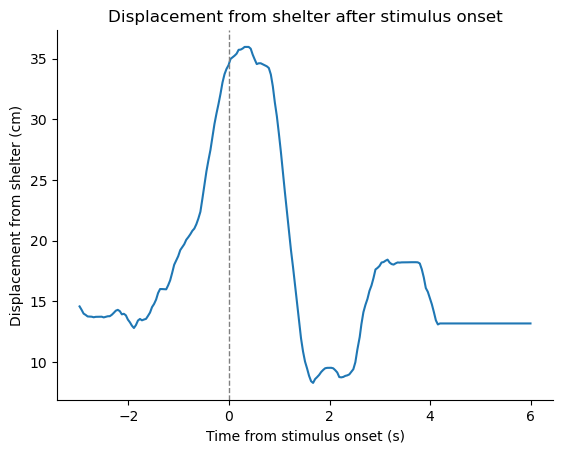

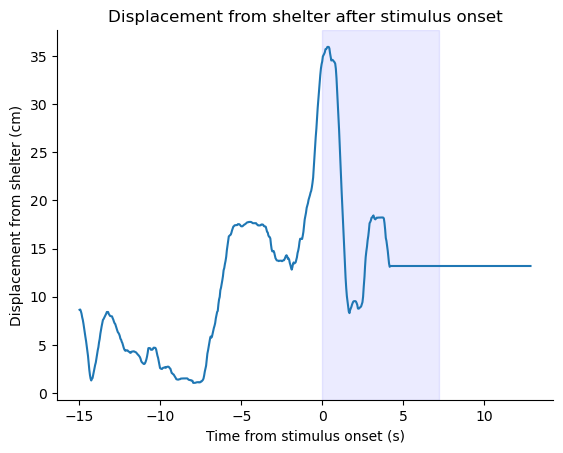

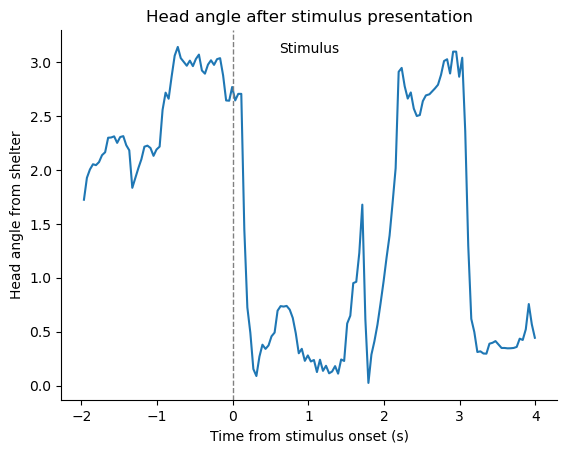

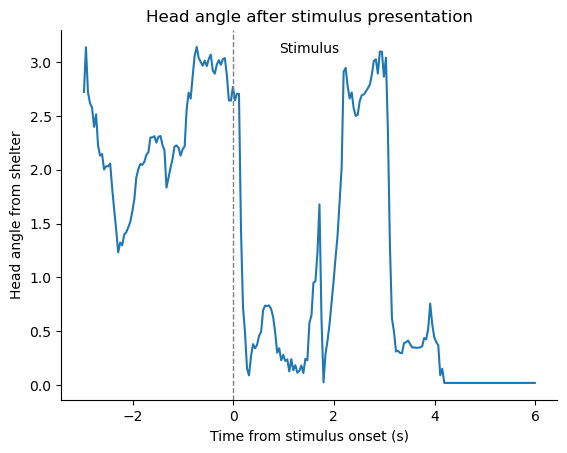

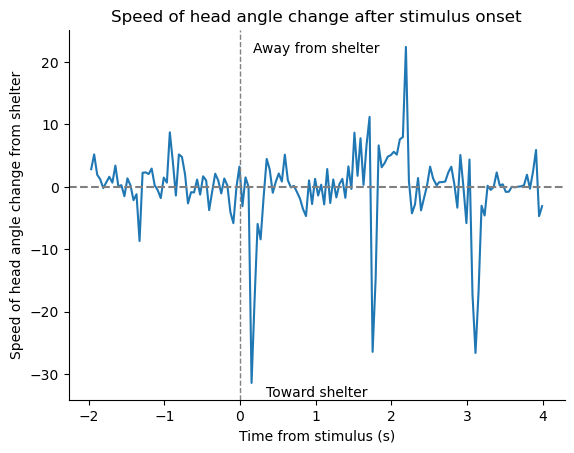

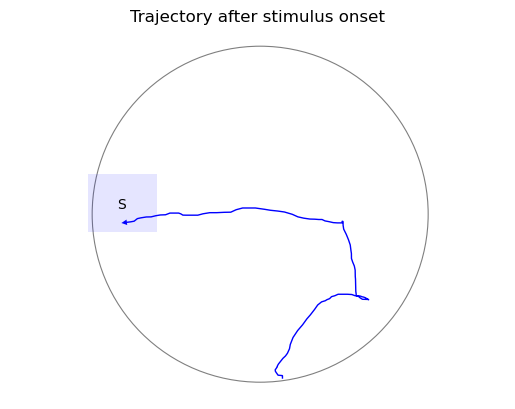

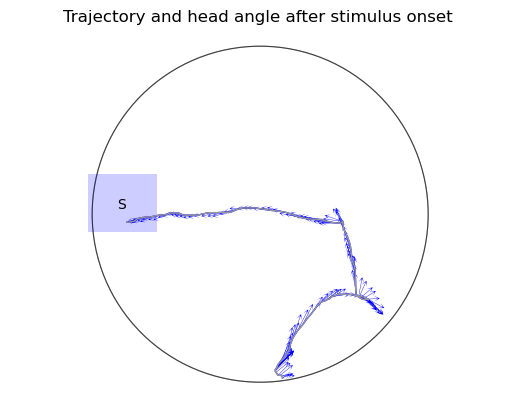

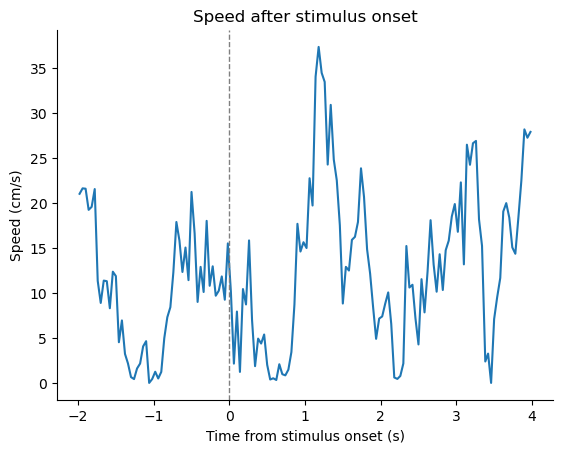

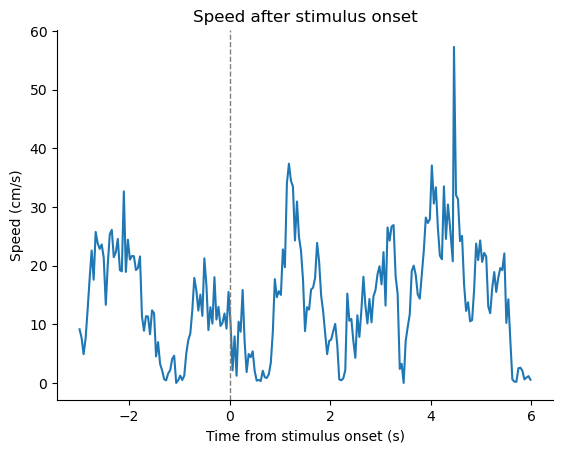

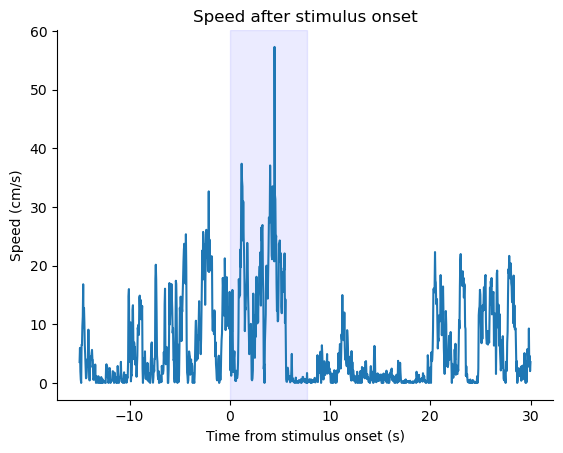

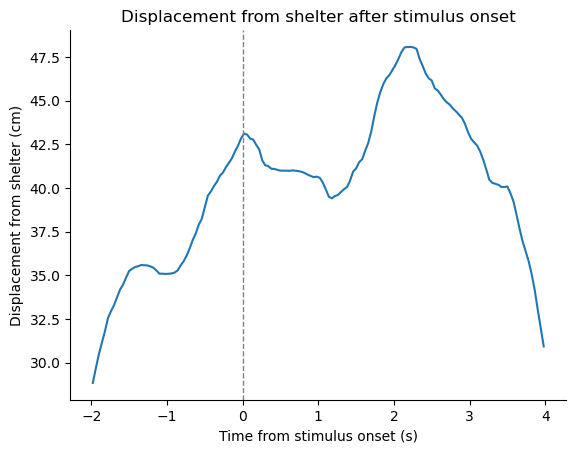

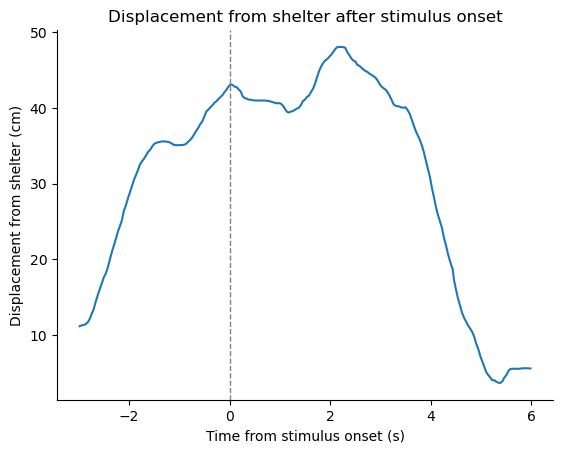

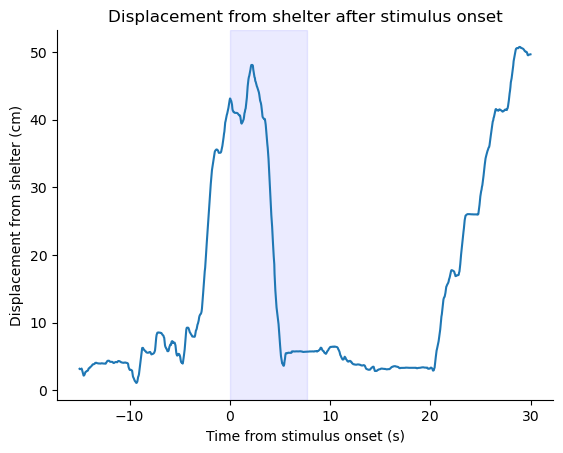

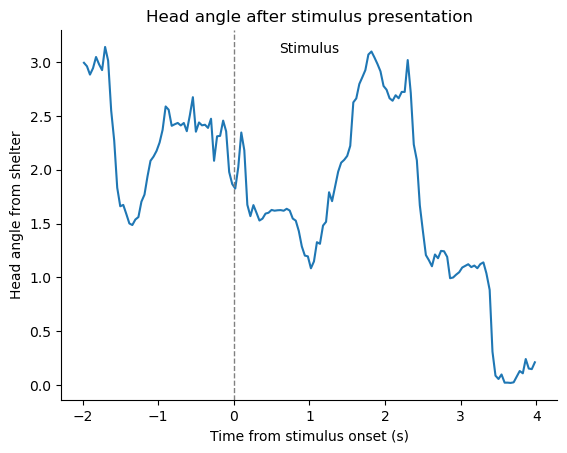

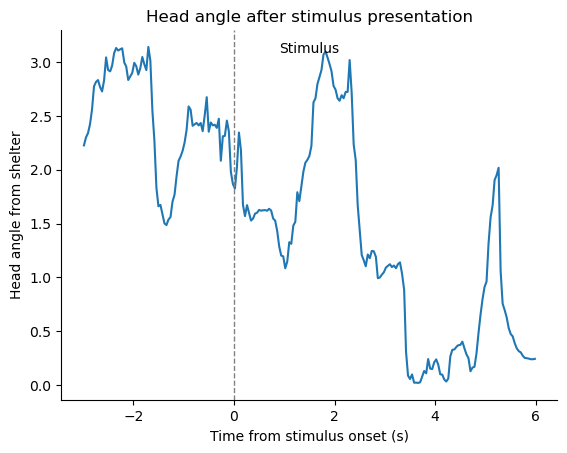

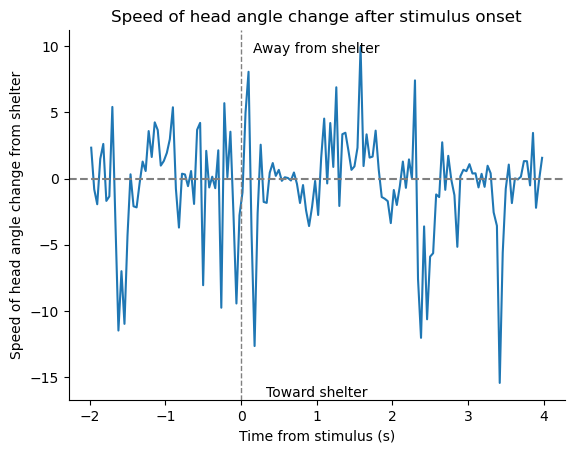

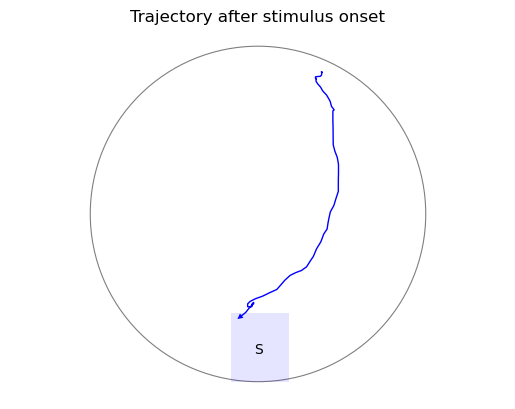

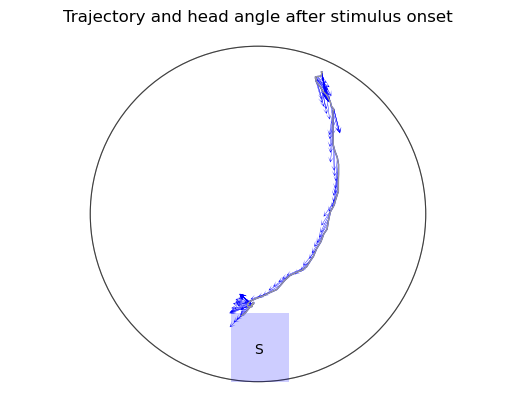

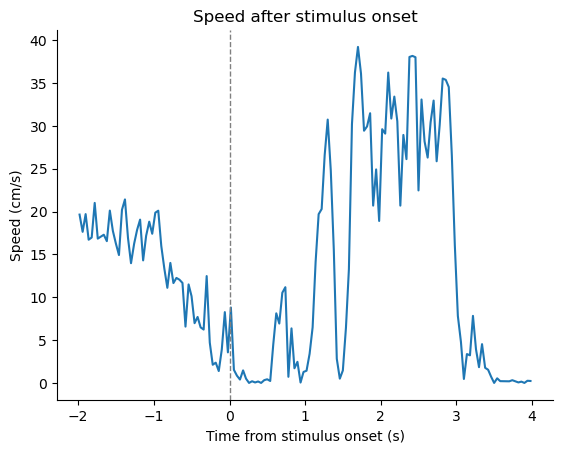

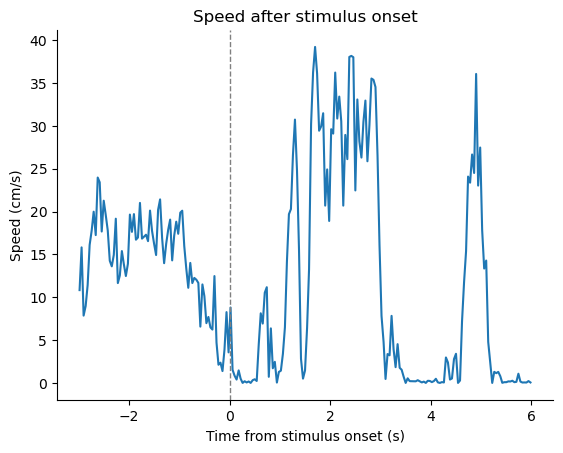

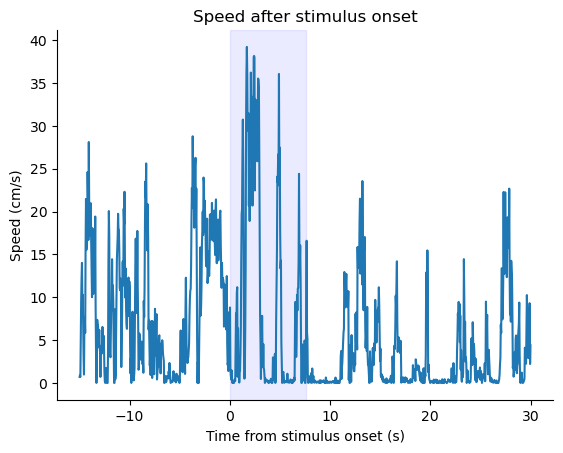

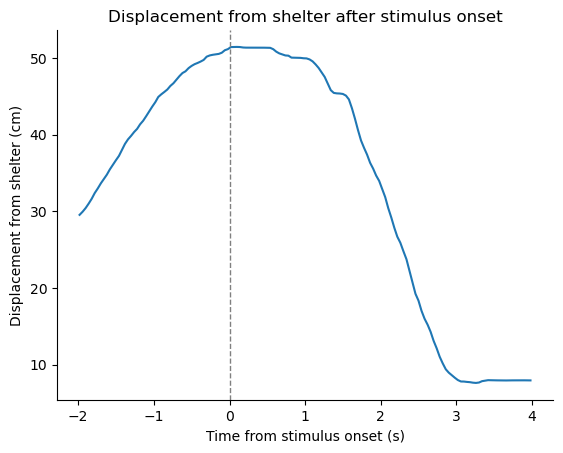

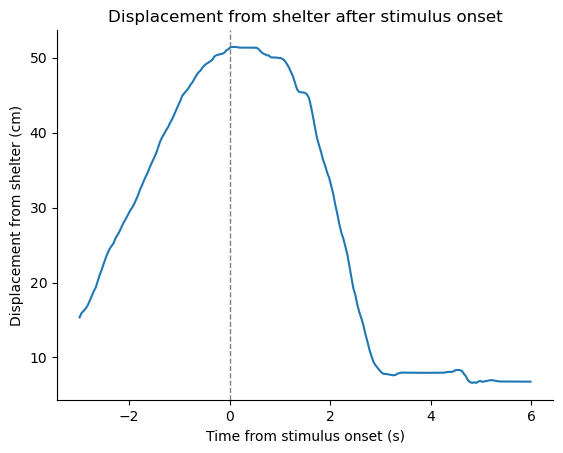

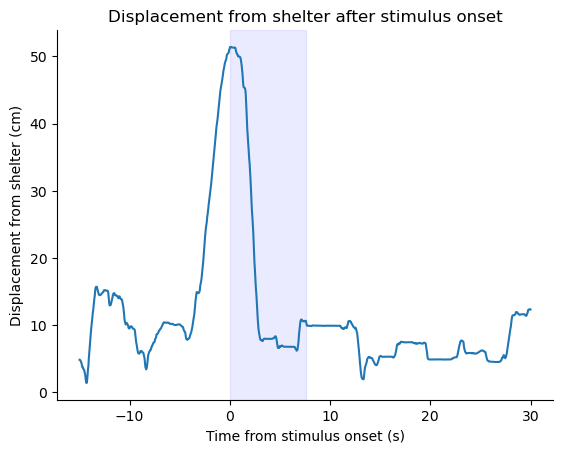

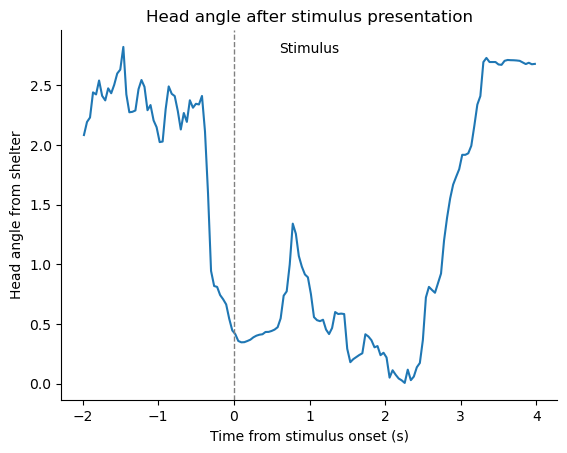

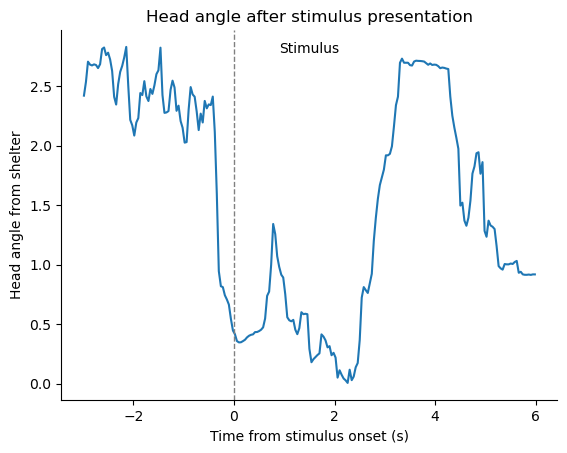

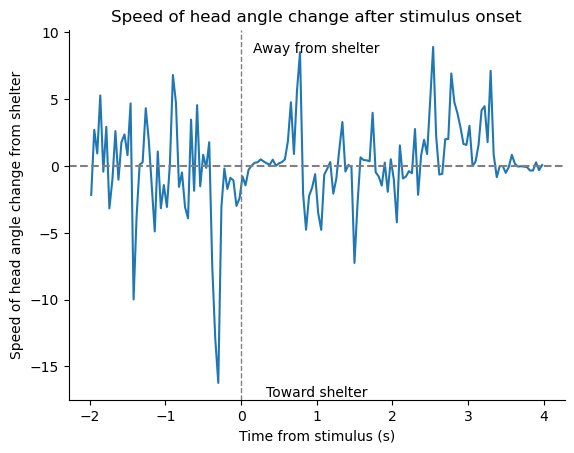

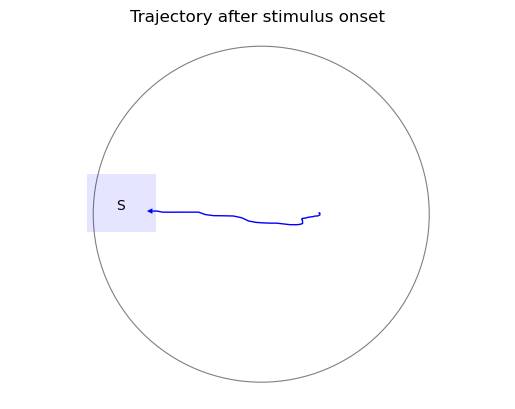

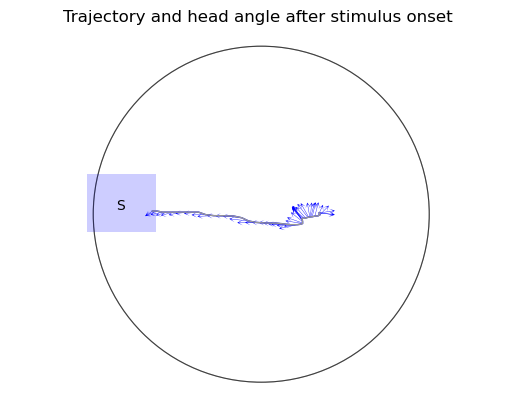

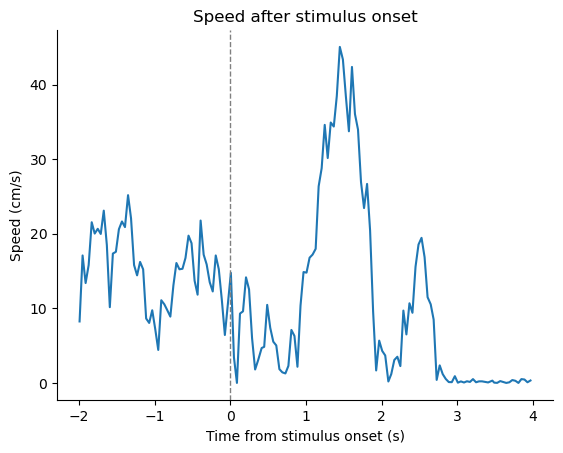

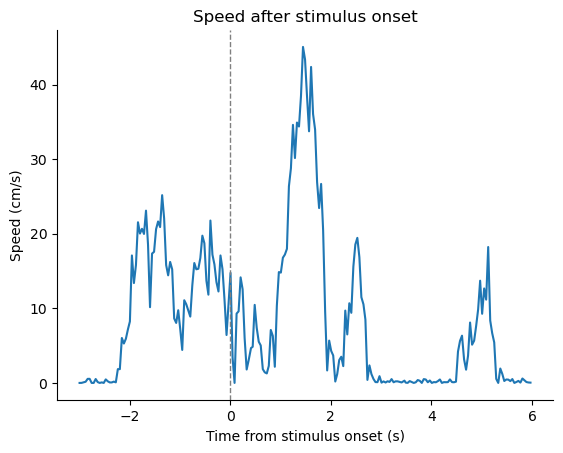

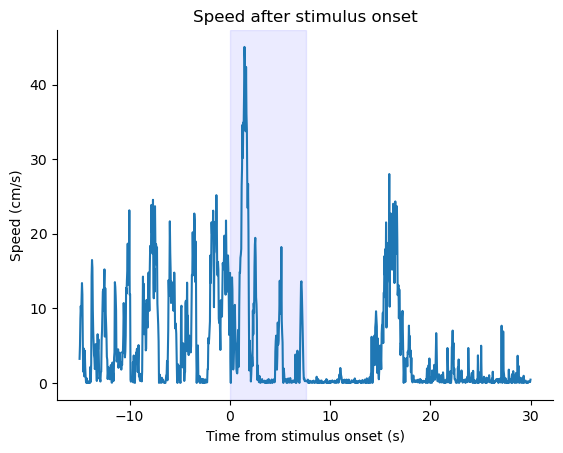

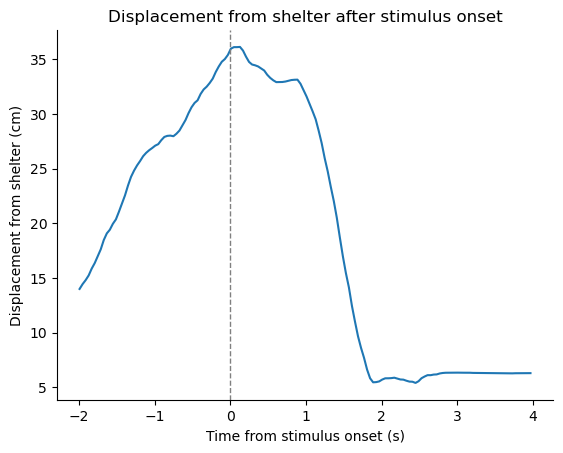

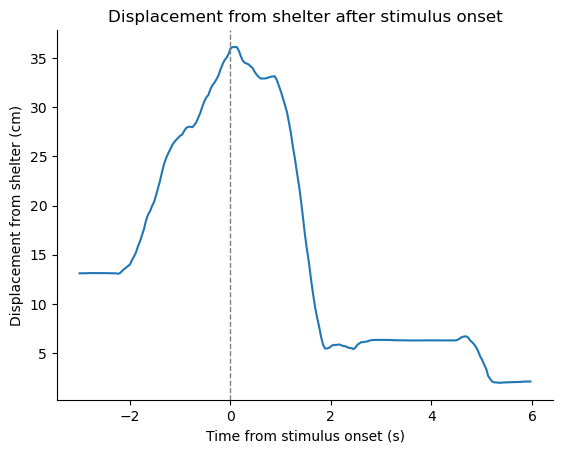

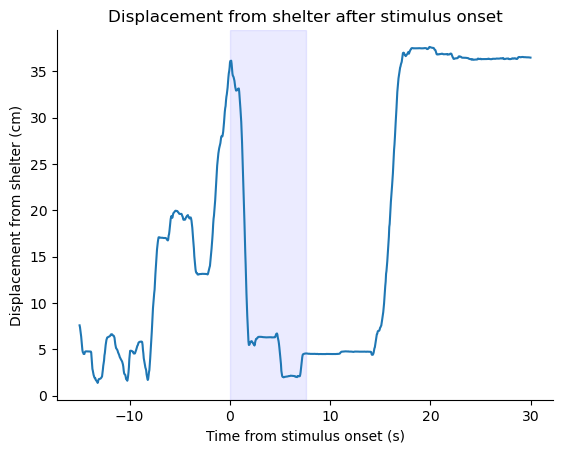

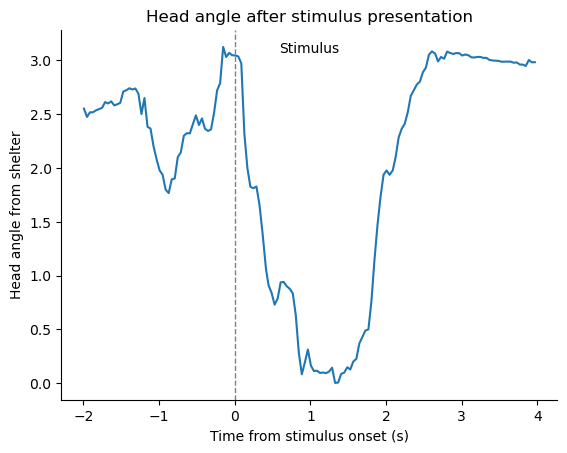

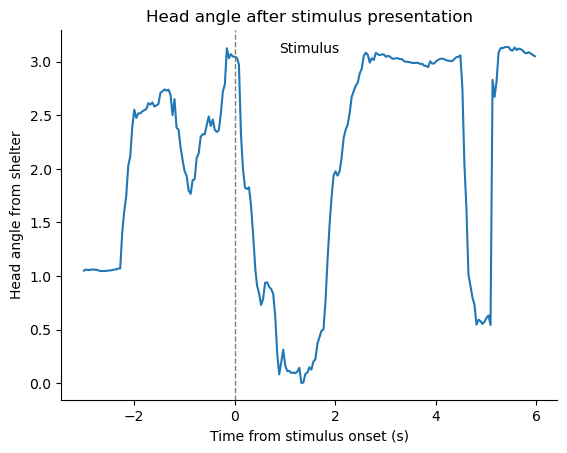

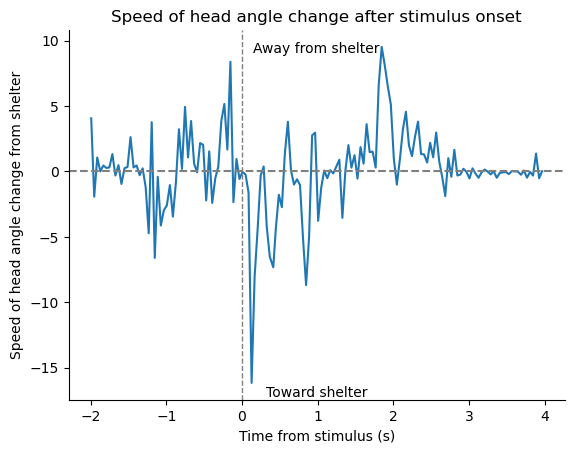

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.patches as patches
import librosa


In [2]:
#returns a dataframe where all rows have at least 1 likelihood value below .9
#Assess how well DLC is labeling data:
def likelihood_check(start, stop, likelihood, dataframe):
    #choose likelihood to look at 
    LT = likelihood
    
    #choose range to look at
    df = dataframe[(dataframe['time_set']>=start) & (dataframe['time_set']<stop)] #not filtered
    
    #Create a dataframe with rows where at least one of the coordinates has likelihood below .9. Can print out to see how much/where DLC is struggling.
    #input different dataframes to assess different time frames 
    likelihood_data = df[(df['nose_likelihood'] < LT) | (df['head_likelihood'] < LT) | (df['earRight_likelihood'] < LT) | (df['earLeft_likelihood'] < LT) | (df['spine1_likelihood'] < LT) | (df['center_likelihood'] < LT) | (df['spine2_likelihood'] < LT) | (df['spine3_likelihood'] < LT)]
    likelihood_minus_nose = df[(df['head_likelihood'] < LT) | (df['earRight_likelihood'] < LT) | (df['earLeft_likelihood'] < LT) | (df['spine1_likelihood'] < LT) | (df['center_likelihood'] < LT) | (df['spine2_likelihood'] < LT) | (df['spine3_likelihood'] < LT)]
    likelihood_center = df[(df['center_likelihood'] < LT)]
    
    return likelihood_data, likelihood_minus_nose, likelihood_center

In [3]:
#replace any low likelihood rows with NA (don't deleted any rows). Use only for Nose, head, and center (only look in detail at these coordinates)-- revisit threshold!
#only replace for those sets of x,y coordinates (don't remove center coordinates if nose is low)

def filter_data(threshold, df):
    LT = threshold  # Threshold value
    
    # Apply filtering row-wise using .loc. Replace with NA
    df.loc[df['nose_likelihood'] < LT, ['nose_x', 'nose_y']] = np.nan
    df.loc[df['head_likelihood'] < LT, ['head_x', 'head_y']] = np.nan
    df.loc[df['center_likelihood'] < LT, ['center_x', 'center_y']] = np.nan
    
    
    #CHECK THIS - filling na values with interpolated values to fill gap in graphs
    df['nose_x'] = df['nose_x'].interpolate()
    df['nose_y'] = df['nose_y'].interpolate()
    df['head_x'] = df['head_x'].interpolate()
    df['head_y'] = df['head_y'].interpolate()
    df['center_x'] = df['center_x'].interpolate()
    df['center_y'] = df['center_y'].interpolate()

In [4]:
#create dataframes isolated to 4 ranges: just shelter reaching, 3 seconds before and 6 after, 2 before and 4 after, and 1 where you can input your own parameters
#return 4 dataframes 
def dataframe_ranges(start, stop, escape, coord_scaled):
    
    escape_estimate = coord_scaled[(coord_scaled['time_set']>=0) & (coord_scaled['time_set']<escape)]
    
    four_second = coord_scaled[(coord_scaled['time_set']>=-2) & (coord_scaled['time_set']<4)]
    
    six_second = coord_scaled[(coord_scaled['time_set']>=-3) & (coord_scaled['time_set']<6)]

    long_range = coord_scaled[(coord_scaled['time_set']>=start) & (coord_scaled['time_set']<stop)]
    
    #get more precise escape time:
    new_time = escape_time(escape_estimate)
    
    escape_only = coord_scaled[(coord_scaled['time_set']>=0) & (coord_scaled['time_set']<new_time)]
    
    return escape_only, four_second, six_second, long_range

In [5]:
#returns closest time 
#think about way to avoid manually finding escape time? This function finds closest shelter time, have to give general parameter to look at
def escape_time(df):
    
    closest_distance = df['displacement'].min()
    closest_distance_index = df['displacement'].idxmin()
    closest_time = df['time_set'].loc[closest_distance_index]
    return closest_time


In [6]:
#returns total seconds of a timestamp given in H:M:S.ms

#adds a zeroed timestamp to the existing dataframe
#called in convert_time
def total_seconds(x):
    #split up string given as H:M:S.ms
    split_string = x.str.split(':')
    
    #define first break as hour, second as minute, third as seconds. Calculate total seconds from there
    hours = split_string.str[0].astype(int)
    minutes = split_string.str[1].astype(int)
    seconds = split_string.str[2].astype(float)
    return (minutes*60) + (seconds) + (hours*3600)

In [7]:
#adds a new column to df with time where the start where first row is zeroed
def convert_time(timestamp_path, df): 
    
    #read in timestamp from bonsai
    timestamp = pd.read_csv(timestamp_path, header =None, names = ['timestamp'])
    
    #convert timestamp to datetime object
    timestamp['date_time'] = pd.to_datetime(timestamp['timestamp'], format = '%Y-%m-%dT%H:%M:%S%z')
    #convert to H:M:S.ms
    timestamp['naive_time'] = timestamp['date_time'].dt.strftime('%H:%M:%S.%f')
    
    #convert to seconds and zero first row 
    timestamp['seconds'] = total_seconds(timestamp['naive_time'])
    timestamp['zeroed'] = timestamp['seconds'] - timestamp['seconds'].iloc[0]  #REPLACE WITH STIMULUS TIME FOR FUTURE EXPERIMENTS --- set stimulus time as 0 
    
    df['time'] = timestamp['zeroed']

In [8]:
#ONLY USE WHEN MISSING AUDIO TIMESTAMPS 

#returns start and stop times of stimulus
#input manually identified start and stop times, audio path, and videotimestamp
def audio_timing(f_start, f_end, audio_path, videotimestamp):

    #extract information from audio file - amplitude and samples (wav files are lossless). store in new df
    #len(y) gives the number of samples in audiofile 
    y, sr = librosa.load(audio_path, sr = 44100)  
    df = pd.DataFrame(data = y, columns = ['amplitude'])

    #calculate offset time - subtract the length of the video from the length of the audio:
    offset_value = (len(y)/sr) - videotimestamp
    
    #adjust start of stimulus time to align with the video. This method finds slightly earlier stimulus time than actual
    start = f_start - offset_value
    stop = f_end - offset_value 
    return start, stop

In [9]:
#zeroes data so stimulus is at 0s. Stored in new column 'time_set'
#returns the end time of stimulus and time when mouse gets closest to the shelter
#NOT NEEDED FOR FUTURE TRIALS

def time_set_zero(start, stop, escape_time, df):
    df['time_set'] = df['time'] - start
    end = stop - start
    escape = escape_time - start #estimation for when the mouse reaches/is closest to shelter
    
    
    return end, escape

In [10]:
#convert data into cm and adjust shelter location as if platform center is 0,0
#returns shelter_x, shelter_y, x_diam, y_diam, coord_scaled

#this is called in single_mouse_data
def convert_data(n, s, e, w, shelter_x_pixel, shelter_y_pixel, df):
    #find diameter in pixels using DLC points 
    x_diam_pixel = abs(e - w)
    y_diam_pixel = abs(n - s)
    platform_diam_cm = 61
    
    #find conversion for x and y dimensions 
    pixels_per_cm_x = x_diam_pixel/platform_diam_cm
    pixels_per_cm_y = y_diam_pixel/platform_diam_cm
    
    #calculate platform center from edges
    platform_center_x = w + ((e-w)/2)
    platform_center_y = n + ((s-n)/2)
    
    #convert to cm
    platform_x = platform_center_x/pixels_per_cm_x
    platform_y = platform_center_y/pixels_per_cm_y
    
    #convert and shift shelter so that platform is centered at 0,0
    shelter_x = (shelter_x_pixel/pixels_per_cm_x) - platform_x 
    shelter_y = (shelter_y_pixel/pixels_per_cm_y) - platform_y
    
    x_diam = (x_diam_pixel/pixels_per_cm_x)
    y_diam = (y_diam_pixel/pixels_per_cm_y)
    
    #convert the rest of the datapoints in new dataframe - coord_scaled. center platform at 0,0.
    x_columns_to_convert = ['nose_x', 'head_x', 'earRight_x', 'earLeft_x', 'spine1_x', 'spine2_x',  'spine3_x', 'center_x']
    y_columns_to_convert = ['nose_y', 'head_y', 'earRight_y', 'earLeft_y', 'spine1_y', 'spine2_y', 'spine3_y', 'center_y']
    coord_scaled = df.copy()
    coord_scaled[x_columns_to_convert]= (df[x_columns_to_convert]/pixels_per_cm_x) - platform_x
    coord_scaled[y_columns_to_convert]= (df[y_columns_to_convert]/pixels_per_cm_y) - platform_y
    
    return shelter_x, shelter_y, x_diam, y_diam, coord_scaled

In [11]:
#read in data and get timeframes for analyzing parameters
#returns shelter_x, shelter_y, x_diam, y_diam, coord_scaled

#convert all points to cm and center the platform at 0,0. Adjust all points accordingly.
def single_mouse_data(n, s, e, w, shelter_x_pixel, shelter_y_pixel, video_path):
    #read by default 1st sheet of an excel file
    coord = pd.read_csv(video_path)
    shelter_x, shelter_y, x_diam, y_diam, coord_scaled = convert_data(n, s, e, w, shelter_x_pixel, shelter_y_pixel, coord)
    
    return shelter_x, shelter_y, x_diam, y_diam, coord_scaled

In [12]:
#calculate displacement from shelter:
#adds new displacement column to df
def displacement(shelter_x, shelter_y, df):
    x_disp = df['center_x'].to_numpy() - shelter_x
    y_disp = df['center_y'].to_numpy() - shelter_y
    displacement = np.sqrt(x_disp**2 + y_disp**2)
    df['displacement'] = displacement

In [13]:
#calculate speed of mouse:
#add new column to df for speed and delta_vector (to find linearity ratio)
def speed(df):
    #create empty data frame to store information
    speed = pd.DataFrame()

    #calculate change in position and time between rows for x and y respectively
    speed['delta_x'] = df['center_x'].diff()
    speed['delta_y'] = df['center_y'].diff()
    speed['delta_time'] = df['time_set'].diff()

    #calculate speed from distance/time
    speed['delta_vector'] = np.sqrt(speed['delta_x']**2 + speed['delta_y']**2)
    speed['speed'] = speed['delta_vector'] / speed['delta_time']

    #add speed to original data frame:
    df['speed'] = speed['speed']
    
    #also add delta_vector to dataframe for linearity ratio calculation
    df['delta_vector'] = speed['delta_vector']

In [14]:
#calculate head angle from shelter and add to new column 'head_angle' in df

#create new dataframe for intermediate steps
def angle(shelter_x, shelter_y, df):
    angle = pd.DataFrame()

    #vector from head to nose
    angle['delta_x_nose'] = df['nose_x'] - df['head_x']
    angle['delta_y_nose'] = df['nose_y'] - df['head_y']
    angle['distance_nose'] = np.sqrt(angle['delta_x_nose']**2 + angle['delta_y_nose']**2)

    #vector from head to center of shelter
    angle['delta_x_shelter'] = shelter_x - df['head_x']
    angle['delta_y_shelter'] = shelter_y - df['head_y']
    angle['distance_shelter'] = np.sqrt(angle['delta_x_shelter']**2 + angle['delta_y_shelter']**2)

    #calculate dot product
    angle['dot'] = (angle['delta_x_nose']) * (angle['delta_x_shelter']) + (angle['delta_y_nose']) * (angle['delta_y_shelter'])

    #calculate head angle from dot product geometry
    angle['head_angle'] = np.arccos(angle['dot'] / (angle['distance_shelter'] * angle['distance_nose']))
    df['head_angle'] = angle['head_angle']


In [15]:
#speed of head angle change

#same code as velocity escept change in angle over time
def angle_speed(df):
    angle_speed = pd.DataFrame()
   
    angle_speed['delta_angle'] = df['head_angle'].diff()
    angle_speed['delta_time'] = df['time_set'].diff()

    angle_speed['angle_speed'] = angle_speed['delta_angle'] / angle_speed['delta_time']
    df['angle_speed'] = angle_speed['angle_speed']

In [16]:
#plot trajectory using center point
#use escape dataframe to just see escape path
def trajectory(shelter_x, shelter_y, x_diam, y_diam, df):
    
    fig = plt.figure()  #create figure to fill in
    ax = plt.axes()
    #make x and y scales equal - present as a circle
    plt.axis('equal')


    #plot the center x and y coordinates
    x = df['center_x']
    y = df['center_y']
    
    #normalize time and set as t (for time colorscale): FIGURE OUT COLOR SCALE
    t = normalize(df['time_set'])

    #plot the platform and shelter
    platform = Ellipse(xy = (0, 0), width = x_diam, height = y_diam, edgecolor = 'black', facecolor = 'none', alpha = .5, linewidth = .8)

    #determine orientation of platform based on platform location 
    if shelter_x<-15 or shelter_x>15:
        shelter = patches.Rectangle(((shelter_x - 6.25), (shelter_y-5.25)), 12.5,10.5,  linewidth = .8, edgecolor = 'none', facecolor = 'blue', alpha = .1)
        
    else:
        shelter = patches.Rectangle(((shelter_x - 5.25), (shelter_y-6.25)), 10.5,12.5,  linewidth = .8, edgecolor = 'none', facecolor = 'blue', alpha = .1)
        
   
    plt.text(shelter_x-1,shelter_y-1, 'S', color = 'black', size = 10)

    ax.plot(x,y, color = 'blue', linewidth = 1)
    ax.add_patch(platform)
    ax.add_patch(shelter)

    #add an arrow to show mouse's direction
    #add an arrow to show mouse's direction
    xf = df['center_x'].iloc[-1] #final x coordinate
    xo = df['center_x'].iloc[-2] #second to last x coordinate

    yf = df['center_y'].iloc[-1] #final y coordinate
    yo = df['center_y'].iloc[-2] #second to last y coordinate

    #plot arrow: base x, base y, displacement x, displacement y
    plt.arrow(xo, yo, xf-xo, yf-yo, head_width = 1, head_length = 1, fc = 'blue', ec = "none")
    ax.set_title('Trajectory after stimulus onset')  #would be after stimulus
    ax.set_xlabel('x-position (cm)', fontsize=12)
    ax.set_ylabel('y-position (cm)', fontsize=12)

    #remove axes
    plt.axis('off')

        
    return plt

In [17]:
#create a new data table with data needed for arrows
#same as plain trajectory 
def head_angle_trajectory_figure(shelter_x, shelter_y, x_diam, y_diam, df):
    plt.figure()
    ax = plt.axes()
    plt.axis('equal')

    #create new dataframe for arrow calculation
    arrow = pd.DataFrame()

    arrow['arrow_base_x'] = df['center_x']
    arrow['arrow_base_y'] = df['center_y']
    arrow['arrow_delta_x'] = df['nose_x'] - df['head_x']
    arrow['arrow_delta_y'] = df['nose_y'] - df['head_y']
    arrow['delta_x_nose'] = df['nose_x'] - df['head_x']
    arrow['delta_y_nose'] = df['nose_y'] - df['head_y']

    for x,y,dx,dy in zip(arrow['arrow_base_x'], arrow['arrow_base_y'], arrow['arrow_delta_x'], arrow['arrow_delta_y']):
        ax.arrow(x,y,dx*2,dy*2, width = .07, head_width = 1, head_length = 1, overhang =.7, fc = 'b', ec = 'none', length_includes_head =True)

    #head angle with position graphic    
    x = df['center_x']
    y = df['center_y']

    platform = Ellipse(xy = (0, 0), width = x_diam, height = y_diam, edgecolor = 'black', facecolor = 'none', alpha = .5, linewidth = .8)
   
    if shelter_x<-15 or shelter_x>15:
        shelter = patches.Rectangle(((shelter_x - 6.25), (shelter_y-5.25)), 12.5,10.5,  linewidth = .8, edgecolor = 'none', facecolor = 'blue', alpha = .1)
        
    else:
        shelter = patches.Rectangle(((shelter_x - 5.25), (shelter_y-6.25)), 10.5,12.5,  linewidth = .8, edgecolor = 'none', facecolor = 'blue', alpha = .1)

    plt.text(shelter_x-1,shelter_y-1, 'S', color = 'black', size = 10)
    
    ax.plot(x,y, color = 'blue', linewidth = 1)
    ax.add_patch(platform)
    ax.add_patch(shelter)

    ax.plot(x,y, color = (.6,.6,.6), linewidth = 1)
    ax.add_patch(platform)
    ax.add_patch(shelter)
    ax.set_xlabel('x-position (cm)')
    ax.set_ylabel('y-position (cm)')
    ax.set_title('Trajectory and head angle after stimulus onset')
    
    plt.axis('off')

    return plt

In [18]:
def speed_figure(stop, length, df):
    plt.figure()
    ax = plt.axes()

    x = df['time_set']
    y = df['speed']

    ax.plot(x,y)
    ax.set_xlabel('Time from stimulus onset (s)')
    ax.set_ylabel('Speed (cm/s)') #convert to cm - cm/s
    ax.set_title('Speed after stimulus onset')



    if length<8:
        plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Vertical Line')
    else:
        plt.axvspan(0, stop, color = 'b', alpha =.08)
        
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    return plt

In [19]:
def displacement_figure(stop, length, df):
    plt.figure()
    ax = plt.axes()

    #graph of displacement vs time after stimulus plt.figure() ax = plt.axes()

    x = df['time_set']
    y = df['displacement']

    ax.plot(x,y)
    ax.set_xlabel('Time from stimulus onset (s)')
    ax.set_ylabel('Displacement from shelter (cm)') #convert to cm - cm/s
    ax.set_title('Displacement from shelter after stimulus onset')


    if length<8:
        plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Vertical Line')
    else:
        plt.axvspan(0, stop, color = 'b', alpha =.08)
 
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    return plt

In [20]:
def head_angle_figure(stop, length, df):
    plt.figure()
    ax = plt.axes()

    x = df['time_set']
    y = df['head_angle']
    
    ax.plot(x,y)
    ax.set_xlabel('Time from stimulus onset (s)')
    ax.set_ylabel('Head angle from shelter')
    ax.set_title('Head angle after stimulus presentation')

    if length<8:
        plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Vertical Line')
    else:
        plt.axvspan(0, stop, color = 'b', alpha =.08)
        
    ax.text(.5,.93, 'Stimulus', ha = 'center', va = 'bottom', transform = ax.transAxes) 
   
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    return plt

In [21]:
#define total linear displacement as distance from first coordinate to last
#only calculate for succesful shelter reaching mice - use escape only times

def linearity_ratio(df):
    total_distance = np.sum(df['delta_vector'])
    #calculate initial linear displacement from ending point 
    displacement_x = df['center_x'].iloc[0] - df['center_x'].iloc[-1] #last x coordinate of mouse in time frame
    displacement_y = df['center_y'].iloc[0] - df['center_y'].iloc[-1] #last y coordinate of mouse in time frame 
    initial_displacement = np.sqrt(displacement_x**2 + displacement_y**2)


    #find ratio - total distance traveled / initial displacement -- smaller is more linear
    ratio = initial_displacement/total_distance
    
    return ratio, initial_displacement, total_distance


In [22]:
#average angle change in head angle speed

#head angle vs displacement from shelter
#average angle change in head angle speed

#head angle vs displacement from shelter
def angle_speed_figure(stop, length, df):
    plt.figure()
    ax = plt.axes()

    x = df['time_set']
    y = df['angle_speed']

    ax.plot(x,y)
    ax.set_xlabel('Time from stimulus (s)')
    ax.set_ylabel('Speed of head angle change from shelter')
    ax.set_title('Speed of head angle change after stimulus onset')

    ax.axhline(y=0, color = 'gray', linestyle = '--')

    if length<8:
        plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Vertical Line')
    else:
        plt.axvspan(0, stop, color = 'b', alpha =.08)

    ax.text(.5,.0, 'Toward shelter', ha = 'center', va = 'bottom', transform = ax.transAxes) 
    ax.text(.5,.93, 'Away from shelter', ha = 'center', va = 'bottom', transform = ax.transAxes) 

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    return plt

In [23]:
#return normalized df
def normalize(df):
    min_value = df.min()
    max_value = df.max()
    range_value = max_value - min_value
    normalized = (df - min_value) / range_value
    return normalized

In [28]:
#Return the rotated trajectory and rotated shelter x and y coordinates
def rotate_trajectory(shelter_x, shelter_y,df):
    rotated = pd.DataFrame()
    shelter_rotated = pd.DataFrame()
    
    #store x and y values as x and y arrays
    x = df['center_x'].values
    y = df['center_y'].values
    
    #initial x and y values to recenter the data:
    initial_x = x[0]
    initial_y = y[0]
    
    #set the start of stimulus location as 0,0
    x_shift = x - initial_x
    y_shift = y - initial_y
    shelter_x_shift = shelter_x - initial_x
    shelter_y_shift = shelter_y - initial_y
    
    #shift the shelter too:
    shelter_x_shift = shelter_x - initial_x
    shelter_y_shift = shelter_y - initial_y
    
    
    #rotate the trajectory so that shelter is on vertical 
    #find angle between vector to shelter and vector to vertical. Rotate by that angle 
    delta_x_shelter = shelter_x - initial_x
    delta_y_shelter = shelter_y - initial_y
    vector_shelter = np.sqrt(delta_x_shelter**2 + delta_y_shelter**2)
    
    delta_x_point = 0 #same initial x
    delta_y_point = 10   #initial y plus 10 in vertical
    vector_point = np.sqrt(delta_x_point**2 + delta_y_point**2)
    
    
    #find the angle between the two points with cross product: 
    dot = delta_x_shelter * delta_x_point + delta_y_shelter * delta_y_point
    angle = np.arccos(dot / (vector_shelter * vector_point))
    
    if shelter_x_shift<0:
        angle = -angle  
    
    #rotate vector with rotation matrix:
    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
    coords = np.vstack((x_shift, y_shift))
    shelter_coords = np.vstack((shelter_x_shift, shelter_y_shift))
   
    rotated_coords = rotation_matrix @ coords
    rotated_shelter_coords = rotation_matrix @ shelter_coords
    
    rotated['rotated_x'] = rotated_coords[0]
    rotated['rotated_y'] = rotated_coords[1]

    shelter_rotated_x = rotated_shelter_coords[0]
    shelter_rotated_y = rotated_shelter_coords[1]

    
    return rotated, shelter_rotated_x, shelter_rotated_y

In [1]:
def normalize_rotation(rotate, shelter_rotate_x, shelter_rotate_y):
    normalized = pd.DataFrame()
    
    #these are all rotated but not normalized values 
    x = rotate['rotated_x']
    y = rotate['rotated_y']
    shelter_x = shelter_rotate_x
    shelter_y = shelter_rotate_y
    
    #add the shelter coordinates to the x and y arrays - include in the normalization range. Shelter should be at 0, 1
    x_with_shelter = np.append(x, shelter_x)
    y_with_shelter = np.append(y, shelter_y)
    
    #find the min, max and range in the whole dataset for normalization
    combined_min = min(x_with_shelter.min(), y_with_shelter.min())
    combined_max = max(x_with_shelter.max(), y_with_shelter.max())
    combined_range = combined_max - combined_min    
    
    #normalize all values 
    x_norm = (x - combined_min) / combined_range
    y_norm = (y - combined_min) / combined_range

    shelter_normalized_x = (shelter_x - combined_min) / combined_range
    shelter_normalized_y = (shelter_y - combined_min) / combined_range
    
    shelter_norm_x = shelter_normalized_x - x_norm[0]
    shelter_norm_y = shelter_normalized_y - y_norm[0]
    
    normalized['x'] = x_norm - x_norm[0]
    normalized['y'] = y_norm - y_norm[0]
    
    
    return normalized, shelter_norm_x, shelter_norm_y, combined_range